<a href="https://colab.research.google.com/github/ShamaLopes10/RealTime-Face-Detection-System/blob/main/CG_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.18.0
OpenCV Version: 4.11.0
Setup cell executed.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded dataset from: /content/fer2013.csv
Dataset shape: (35887, 3)
First 5 rows:
    emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Distribution of 'Usage' column:
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

Shape of train_df: (28709, 3)
Shape of val_df (for validation): (3589, 3)
Shape of test_df (for testing): (3589, 3)

Processed X_train shape: (

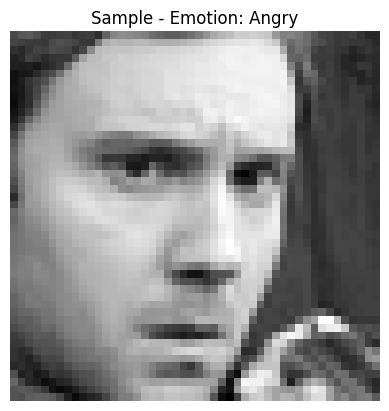


Data loading and preprocessing cell executed.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2 # OpenCV for image processing and Haar Cascade
from google.colab import drive # For Google Drive access
from google.colab import files # For uploading files (alternative to Drive)
from google.colab.patches import cv2_imshow # For displaying OpenCV images in Colab
from IPython.display import display, Javascript, Image # For webcam interaction
from base64 import b64decode, b64encode # For webcam data encoding/decoding
from google.colab.output import eval_js # For executing JS and getting results

# --- Configuration ---
IMG_WIDTH, IMG_HEIGHT = 48, 48
NUM_CLASSES = 7 # Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral
EMOTION_LABELS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
BATCH_SIZE = 64
EPOCHS = 60 # Adjust as needed, EarlyStopping will often stop it sooner

print("TensorFlow Version:", tf.__version__)
print("OpenCV Version:", cv2.__version__)
print("Setup cell executed.")

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- Define Path to your fer2013.csv file on Google Drive ---
# !!! IMPORTANT: ADJUST THIS PATH if your file is located elsewhere in your Drive !!!
FER2013_CSV_PATH = '/content/fer2013.csv'

# --- Load Data ---
try:
    df = pd.read_csv(FER2013_CSV_PATH)
    print(f"Successfully loaded dataset from: {FER2013_CSV_PATH}")
    print("Dataset shape:", df.shape)
    print("First 5 rows:\n", df.head())

    # --- CRITICAL CHECK: 'Usage' column distribution ---
    if 'Usage' in df.columns:
        print("\nDistribution of 'Usage' column:")
        print(df['Usage'].value_counts())
        if 'PublicTest' not in df['Usage'].value_counts() or df['Usage'].value_counts()['PublicTest'] == 0:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("CRITICAL WARNING: 'PublicTest' usage category is missing or has 0 samples.")
            print("Validation data will be empty. Please check your fer2013.csv file.")
            print("Ensure it's the standard FER2013 dataset with 'Training', 'PublicTest', and 'PrivateTest' splits.")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if 'PrivateTest' not in df['Usage'].value_counts() or df['Usage'].value_counts()['PrivateTest'] == 0:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("CRITICAL WARNING: 'PrivateTest' usage category is missing or has 0 samples.")
            print("Test data will be empty. Please check your fer2013.csv file.")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
    else:
        raise ValueError("'Usage' column not found in the CSV. Please check your fer2013.csv file.")

except FileNotFoundError:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"CRITICAL ERROR: File not found at '{FER2013_CSV_PATH}'.")
    print("Please ensure the path is correct and the file exists in your Google Drive.")
    print("You might need to upload it or adjust the FER2013_CSV_PATH variable.")
    print("Stopping execution for this cell.")
    raise # Stop execution if file is not found
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    raise

# --- Preprocessing Function ---
def preprocess_data(dataframe, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_classes=NUM_CLASSES):
    if dataframe.empty:
        print("Warning: Received an empty dataframe for preprocessing. Returning empty arrays.")
        return np.array([]), np.array([])

    images = []
    labels = []
    for index, row in dataframe.iterrows():
        pixels_str = row.get('pixels', '') # Use .get for safety
        if not pixels_str:
            print(f"Warning: Empty pixel string for row {index}. Skipping.")
            continue
        pixels = np.array(pixels_str.split(' '), dtype='float32')
        if pixels.shape[0] != img_width * img_height:
            print(f"Warning: Incorrect number of pixels for row {index} (got {pixels.shape[0]}, expected {img_width*img_height}). Skipping.")
            continue
        image = pixels.reshape((img_width, img_height))
        images.append(image)
        labels.append(row['emotion'])

    if not images: # If all rows were skipped
        print("Warning: No valid images found after parsing pixels. Returning empty arrays.")
        return np.array([]), np.array([])

    images_np = np.array(images)
    labels_np = np.array(labels)

    # Normalize images
    images_np = images_np / 255.0

    # Reshape for CNN (add channel dimension)
    images_np = images_np.reshape(images_np.shape[0], img_width, img_height, 1)

    # One-hot encode labels
    labels_np = to_categorical(labels_np, num_classes=num_classes)

    return images_np, labels_np

# --- Split data based on 'Usage' column ---
# Ensure df is not empty and 'Usage' column exists from checks above
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

print(f"\nShape of train_df: {train_df.shape}")
print(f"Shape of val_df (for validation): {val_df.shape}")
print(f"Shape of test_df (for testing): {test_df.shape}")

# --- Process each split ---
X_train, y_train = preprocess_data(train_df)
X_val, y_val = preprocess_data(val_df)
X_test, y_test = preprocess_data(test_df)

print(f"\nProcessed X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Processed X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Processed X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- CRITICAL CHECKS for processed data ---
if X_train.shape[0] == 0:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("CRITICAL ERROR: Training data (X_train) is empty after preprocessing.")
    print("Cannot proceed with model training. Please check your CSV and preprocessing logic.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    # Consider raising an error here to stop execution if training data is vital
if X_val.shape[0] == 0:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("WARNING: Validation data (X_val) is empty after preprocessing.")
    print("Validation will be skipped during training. Callbacks monitoring validation metrics may not work as expected.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
if X_test.shape[0] == 0:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("WARNING: Test data (X_test) is empty after preprocessing.")
    print("Final model evaluation on the test set will be skipped.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")


# --- Visualize a sample image (if training data exists) ---
if X_train.shape[0] > 0:
    plt.imshow(X_train[0].reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
    plt.title(f"Sample - Emotion: {EMOTION_LABELS[np.argmax(y_train[0])]}")
    plt.axis('off')
    plt.show()
else:
    print("Skipping sample image visualization as X_train is empty.")

print("\nData loading and preprocessing cell executed.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,470,951 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

Validation data found. Callbacks will monitor validation metrics.

--- Starting Model Training ---
Epoch 1/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2764 - loss: 2.2169
Epoch 1: val_accuracy improved from -inf to 0.32154, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.2765 - loss: 2.2161 - val_accuracy: 0.3215 - val_loss: 1.8509 - learning_rate: 0.0010
Epoch 2/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4529 - loss: 1.4416
Epoch 2: val_accuracy improved from 0.32154 to 0.52132, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4530 - loss: 1.4414 - val_accuracy: 0.5213 - val_loss: 1.2645 - learning_rate: 0.0010
Epoch 3/60
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5259 - loss: 1.2521
Epoch 3: val_accuracy improved from 0.52132 to 0.55085, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5259 - loss: 1.2520 - val_accuracy: 0.5508 - val_loss: 1.2152 - learning_rate: 0.0010
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5543 - loss: 1.1717
Epoch 4: val_accuracy improved from 0.55085 to 0.55754, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5543 - loss: 1.1717 - val_accuracy: 0.5575 - val_loss: 1.1745 - learning_rate: 0.0010
Epoch 5/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5807 - loss: 1.1068
Epoch 5: val_accuracy did not improve from 0.55754
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5807 - loss: 1.1069 - val_accuracy: 0.5350 - val_loss: 1.2316 - learning_rate: 0.0010
Epoch 6/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5988 - loss: 1.0658
Epoch 6: val_accuracy improved from 0.55754 to 0.58596, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5988 - loss: 1.0658 - val_accuracy: 0.5860 - val_loss: 1.1538 - learning_rate: 0.0010
Epoch 7/60
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6151 - loss: 1.0234
Epoch 7: val_accuracy improved from 0.58596 to 0.59264, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6151 - loss: 1.0235 - val_accuracy: 0.5926 - val_loss: 1.0958 - learning_rate: 0.0010
Epoch 8/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6205 - loss: 1.0036
Epoch 8: val_accuracy did not improve from 0.59264
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6205 - loss: 1.0037 - val_accuracy: 0.5539 - val_loss: 1.2346 - learning_rate: 0.0010
Epoch 9/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6367 - loss: 0.9646
Epoch 9: val_accuracy improved from 0.59264 to 0.59738, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6367 - loss: 0.9646 - val_accuracy: 0.5974 - val_loss: 1.1145 - learning_rate: 0.0010
Epoch 10/60
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6594 - loss: 0.9178
Epoch 10: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6593 - loss: 0.9180 - val_accuracy: 0.5160 - val_loss: 1.5732 - learning_rate: 0.0010
Epoch 11/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6779 - loss: 0.8621
Epoch 11: val_accuracy improved from 0.59738 to 0.60212, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6779 - loss: 0.8621 - val_accuracy: 0.6021 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 12/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6982 - loss: 0.8235
Epoch 12: val_accuracy improved from 0.60212 to 0.61744, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6981 - loss: 0.8235 - val_accuracy: 0.6174 - val_loss: 1.0459 - learning_rate: 0.0010
Epoch 13/60
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7115 - loss: 0.7765
Epoch 13: val_accuracy did not improve from 0.61744
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7114 - loss: 0.7767 - val_accuracy: 0.5893 - val_loss: 1.1689 - learning_rate: 0.0010
Epoch 14/60
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7117 - loss: 0.7760
Epoch 14: val_accuracy improved from 0.61744 to 0.63082, saving model to /content/drive/MyDrive/fer2013_emotion_model_best.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7116 - loss: 0.7761 - val_accuracy: 0.6308 - val_loss: 1.0622 - learning_rate: 0.0010
Epoch 15/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7364 - loss: 0.7205
Epoch 15: val_accuracy did not improve from 0.63082
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7364 - loss: 0.7206 - val_accuracy: 0.6172 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 16/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7521 - loss: 0.6756
Epoch 16: val_accuracy did not improve from 0.63082
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7521 - loss: 0.6757 - val_accuracy: 0.6308 - val_loss: 1.0813 - learning_rate: 0.0010
Epoch 17/60
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7640 - loss: 0.6467
Epoch 17: val_accuracy did not improve from 0.63082

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7639 - loss: 0.64

449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7981 - loss: 0.5519 - val_accuracy: 0.6531 - val_loss: 1.0598 - learning_rate: 2.0000e-04
Epoch 19/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8186 - loss: 0.5021
Epoch 19: val_accuracy did not improve from 0.65311
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8186 - loss: 0.5020 - val_accuracy: 0.6495 - val_loss: 1.0966 - learning_rate: 2.0000e-04
Epoch 20/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8298 - loss: 0.4639
Epoch 20: val_accuracy did not improve from 0.65311
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8298 - loss: 0.4639 - val_accuracy: 0.6517 - val_loss: 1.1173 - learning_rate: 2.0000e-04
Epoch 21/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8385 - loss: 0.4353
Epoch 21: val_accuracy did not improve from 0.65311
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8385 - loss: 0.4353 - val_accuracy: 0.6489 - val_loss: 1.1592 - learning_rate: 2.000

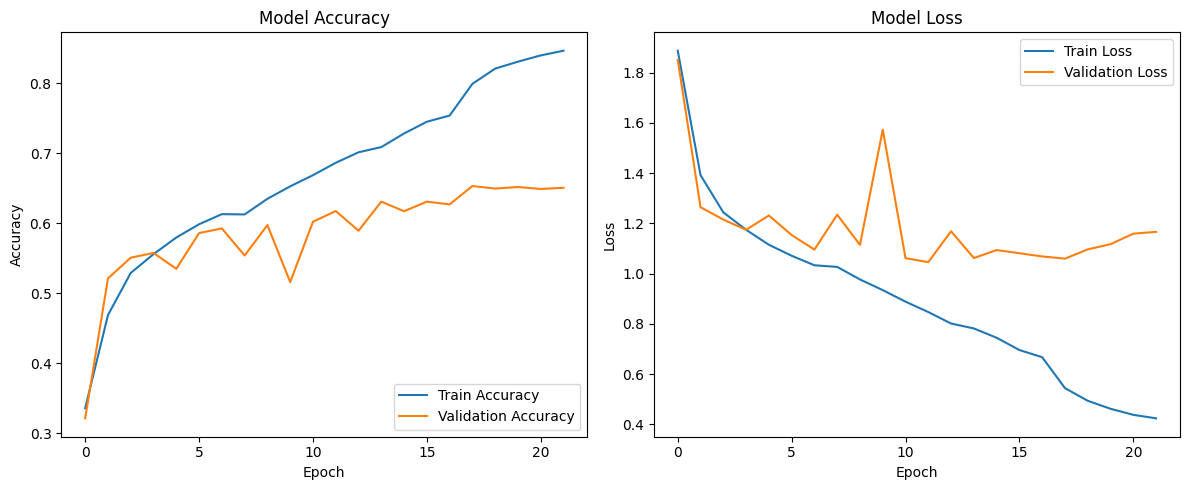


--- Evaluating on Test Set ---


Successfully loaded best model from /content/drive/MyDrive/fer2013_emotion_model_best.h5 for evaluation.
Test Loss: 1.0124
Test Accuracy: 0.6556

Model building, training, and evaluation cell executed.


In [ ]:
def build_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 1), num_classes=NUM_CLASSES):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

# --- Callbacks Configuration ---
# !!! IMPORTANT: ADJUST THIS PATH if you want to save the model elsewhere in your Drive !!!
MODEL_SAVE_PATH = '/content/drive/MyDrive/fer2013_emotion_model_best.h5'
callbacks_list = []
validation_data_for_fit = None
monitor_metric_checkpoint = 'loss' # Default if no validation data
monitor_mode_checkpoint = 'min'
monitor_metric_earlystop_lr = 'loss' # Default if no validation data

if X_val.shape[0] > 0 and y_val.shape[0] > 0:
    print("Validation data found. Callbacks will monitor validation metrics.")
    validation_data_for_fit = (X_val, y_val)
    monitor_metric_checkpoint = 'val_accuracy'
    monitor_mode_checkpoint = 'max'
    monitor_metric_earlystop_lr = 'val_loss'
else:
    print("No validation data (X_val is empty). Callbacks will monitor training metrics.")

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH,
                             monitor=monitor_metric_checkpoint,
                             verbose=1,
                             save_best_only=True,
                             mode=monitor_mode_checkpoint)
callbacks_list.append(checkpoint)

early_stopping = EarlyStopping(monitor=monitor_metric_earlystop_lr,
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)
callbacks_list.append(early_stopping)

reduce_lr = ReduceLROnPlateau(monitor=monitor_metric_earlystop_lr,
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_lr=0.00001)
callbacks_list.append(reduce_lr)

# --- Train the model ---
if X_train.shape[0] > 0:
    print("\n--- Starting Model Training ---")
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=validation_data_for_fit,
                        callbacks=callbacks_list,
                        verbose=1)

    print("\nTraining finished.")
    print("Available keys in history.history:", history.history.keys())

    # --- Plot training history ---
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    elif validation_data_for_fit is None:
        print("Plotting: No validation data was provided, so 'val_accuracy' is not plotted.")
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if 'accuracy' in history.history or 'val_accuracy' in history.history:
        plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    elif validation_data_for_fit is None:
        print("Plotting: No validation data was provided, so 'val_loss' is not plotted.")
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if 'loss' in history.history or 'val_loss' in history.history:
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

else:
    print("CRITICAL: X_train is empty. Skipping model training and evaluation.")
    history = None # Ensure history is defined even if training is skipped

# --- Evaluate on test set (if test data and model training occurred) ---
if history and X_test.shape[0] > 0:
    print("\n--- Evaluating on Test Set ---")
    # Load the best model saved by ModelCheckpoint for evaluation
    try:
        best_model = load_model(MODEL_SAVE_PATH)
        print(f"Successfully loaded best model from {MODEL_SAVE_PATH} for evaluation.")
        test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
    except Exception as e:
        print(f"Could not load the best model from {MODEL_SAVE_PATH}. Error: {e}")
        print("Evaluating with the model state at the end of training (if EarlyStopping restored best weights).")
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss (current model state): {test_loss:.4f}")
        print(f"Test Accuracy (current model state): {test_accuracy:.4f}")

elif not history:
    print("\nSkipping evaluation on test set because model training was skipped (X_train was empty).")
elif X_test.shape[0] == 0:
    print("\nSkipping evaluation on test set because X_test is empty.")

print("\nModel building, training, and evaluation cell executed.")

In [ ]:
# --- Download Haar Cascade file for face detection ---
HAAR_CASCADE_URL = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
HAAR_CASCADE_FILENAME = "haarcascade_frontalface_default.xml"
MODEL_SAVE_PATH="/content/fer2013_emotion_model_best.h5"
# Using wget to download
import os
if not os.path.exists(HAAR_CASCADE_FILENAME):
    print(f"Downloading {HAAR_CASCADE_FILENAME}...")
    os.system(f"wget {HAAR_CASCADE_URL} -O {HAAR_CASCADE_FILENAME}")
    if os.path.exists(HAAR_CASCADE_FILENAME):
        print("Download complete.")
    else:
        print(f"ERROR: Failed to download {HAAR_CASCADE_FILENAME}.")
else:
    print(f"{HAAR_CASCADE_FILENAME} already exists.")

# --- Load Haar Cascade for face detection ---
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILENAME)
if face_cascade.empty():
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"CRITICAL ERROR: Failed to load Haar Cascade from '{HAAR_CASCADE_FILENAME}'.")
    print("Face detection will not work. Ensure the file was downloaded correctly.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
else:
    print("Haar Cascade for face detection loaded successfully.")

# --- Load the Trained Emotion Model ---
# Uses MODEL_SAVE_PATH defined in the previous cell
from google.colab import drive
drive.mount('/content/drive')
MODEL_TO_LOAD_PATH = '/content/fer2013_emotion_model_best.h5'

emotion_model = None
try:

    emotion_model = load_model(MODEL_TO_LOAD_PATH)
    print(f"Emotion detection model loaded successfully from: {MODEL_TO_LOAD_PATH}")
except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"CRITICAL ERROR: Failed to load the trained emotion model from '{MODEL_TO_LOAD_PATH}'. Error: {e}")
    print("Real-time emotion prediction will not work correctly. Ensure the model was trained and saved.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    emotion_model = None # Set to None to handle gracefully in the next cell

print("\nReal-time detection setup cell executed.")


haarcascade_frontalface_default.xml already exists.
Haar Cascade for face detection loaded successfully.
Mounted at /content/drive
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
CRITICAL ERROR: Failed to load the trained emotion model from '/content/fer2013_emotion_model_best.h5'. Error: name 'load_model' is not defined
Real-time emotion prediction will not work correctly. Ensure the model was trained and saved.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Real-time detection setup cell executed.


In [ ]:
# NEW TEST CELL - Run this after restarting runtime

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Explicitly import load_model right here
from tensorflow.keras.models import load_model
print(f"Type of load_model after import: {type(load_model)}")

# Ensure Google Drive is mounted if your model is there
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True) # force_remount can sometimes help
    print("Google Drive mounted.")
except Exception as e:
    print(f"Error mounting drive: {e}")

MODEL_PATH_TO_TEST = '/content/fer2013_emotion_model_best.h5' #  <--- VERIFY THIS PATH IS CORRECT
emotion_model_test = None

print(f"\nAttempting to load model from: {MODEL_PATH_TO_TEST}")
try:
    if 'load_model' in globals() and callable(load_model):
        print("'load_model' IS in globals and is callable.")
        emotion_model_test = load_model(MODEL_PATH_TO_TEST)
        if emotion_model_test is not None:
            print("SUCCESS: Model loaded successfully in this isolated test!")
            emotion_model_test.summary()
        else:
            print("ERROR: load_model ran but returned None (model file might be corrupt or not a Keras model).")
    else:
        print("CRITICAL ERROR: 'load_model' is NOT in globals or is not callable, even after import in this cell.")
        # Let's see what load_model is, if it exists
        if 'load_model' in globals():
            print(f"Type of 'load_model' in globals is actually: {type(globals()['load_model'])}")
        else:
            print("'load_model' is not in globals at all.")
        # Let's check tf.keras.models directly
        if hasattr(tf.keras.models, 'load_model'):
            print("tf.keras.models HAS an attribute 'load_model'.")
            print(f"Type of tf.keras.models.load_model is: {type(tf.keras.models.load_model)}")
        else:
            print("tf.keras.models does NOT have an attribute 'load_model'. This is very strange.")


except NameError as ne:
    print(f"NameError during load_model call: {ne}")
    print("This means 'load_model' was still not defined when called.")
except FileNotFoundError:
    print(f"FileNotFoundError: Model file not found at '{MODEL_PATH_TO_TEST}'.")
    print("Please verify the path and ensure the file exists in your Google Drive.")
except Exception as e:
    print(f"An unexpected error occurred while trying to load the model: {e}")
    import traceback
    traceback.print_exc()

TensorFlow version: 2.18.0
Type of load_model after import: <class 'function'>
Mounted at /content/drive
Google Drive mounted.

Attempting to load model from: /content/fer2013_emotion_model_best.h5
'load_model' IS in globals and is callable.


SUCCESS: Model loaded successfully in this isolated test!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,470,953 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# CELL 4: Real-time Detection Setup (REPLACED WITH WORKING CODE)

import tensorflow as tf
print(f"TensorFlow version (Cell 4): {tf.__version__}")

# Explicitly import load_model right here
from tensorflow.keras.models import load_model
print(f"Type of load_model after import (Cell 4): {type(load_model)}")

import os
import cv2 # For Haar Cascade

# Ensure Google Drive is mounted if your model is there
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=False) # force_remount=True if you suspect issues
    print("Google Drive mounted (Cell 4).")
except Exception as e:
    print(f"Error mounting drive (Cell 4): {e}")

# --- Download Haar Cascade file for face detection ---
HAAR_CASCADE_URL = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
HAAR_CASCADE_FILENAME = "haarcascade_frontalface_default.xml"

if not os.path.exists(HAAR_CASCADE_FILENAME):
    print(f"Downloading {HAAR_CASCADE_FILENAME}...")
    os.system(f"wget {HAAR_CASCADE_URL} -O {HAAR_CASCADE_FILENAME}")
    if os.path.exists(HAAR_CASCADE_FILENAME): print("Download complete.")
    else: print(f"ERROR: Failed to download {HAAR_CASCADE_FILENAME}.")
else:
    print(f"{HAAR_CASCADE_FILENAME} already exists.")

# --- Load Haar Cascade for face detection ---
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILENAME)
if face_cascade.empty():
    print("CRITICAL ERROR: Failed to load Haar Cascade.")
else:
    print("Haar Cascade for face detection loaded successfully.")

# --- Load the Trained Emotion Model ---
MODEL_LOAD_PATH = '/content/fer2013_emotion_model_best.h5' # Make sure this is your correct model path
emotion_model = None # Initialize to ensure it's defined

print(f"\nAttempting to load emotion model from: {MODEL_LOAD_PATH}")
try:
    if callable(load_model): # Check if load_model is a callable function
        emotion_model = load_model(MODEL_LOAD_PATH) # Assign to the global 'emotion_model'
        if emotion_model is not None:
            print("SUCCESS: Emotion model loaded successfully!")
            # emotion_model.summary() # Optional: display summary
        else:
            print("ERROR: load_model ran but returned None.")
    else:
        print("CRITICAL ERROR: 'load_model' is not callable in this cell's scope.")
except FileNotFoundError:
    print(f"FileNotFoundError: Model file not found at '{MODEL_LOAD_PATH}'.")
except Exception as e:
    print(f"An unexpected error occurred while loading the model: {e}")
    import traceback
    traceback.print_exc()

# Ensure emotion_model is not None before proceeding to Cell 5
if emotion_model is None:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("CRITICAL ERROR: emotion_model was NOT loaded. Real-time detection will fail.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


print("\nReal-time detection setup cell (Cell 4) executed.")

TensorFlow version (Cell 4): 2.18.0
Type of load_model after import (Cell 4): <class 'function'>
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted (Cell 4).
haarcascade_frontalface_default.xml already exists.
Haar Cascade for face detection loaded successfully.

Attempting to load emotion model from: /content/fer2013_emotion_model_best.h5


SUCCESS: Emotion model loaded successfully!

Real-time detection setup cell (Cell 4) executed.


In [ ]:
# CELL 1: PYTHON BACKEND FOR INTERACTIVE DETECTION

from google.colab.output import register_callback, eval_js
from IPython.display import display, Javascript # Javascript is for the UI cell in Cell 2
import numpy as np
import cv2
from base64 import b64decode, b64encode
import traceback # For detailed error printing

# --- Ensure these are loaded from your previous cells ---
# For example:
# IMG_WIDTH, IMG_HEIGHT = 48, 48
# EMOTION_LABELS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # Make sure this file exists
# emotion_model = load_model('/content/drive/MyDrive/fer2013_emotion_model_best.h5') # Adjust path as needed

# --- Helper function for drawing (should be defined from previous steps) ---
def draw_prediction(frame, x, y, w, h, label_text, color=(0, 255, 0)):
    cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
    cv2.putText(frame, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return frame
# --- End Ensure/Define ---


def detect_emotion_on_captured_frame(base64_image_data_url):
    """
    Processes a single base64 encoded image, performs emotion detection,
    and sends the processed image back to JavaScript.
    """
    try:
        print("Python: Received image data for processing from JS.")

        header, base64_data = base64_image_data_url.split(',', 1)
        image_bytes = b64decode(base64_data)
        frame = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

        if frame is None:
            print("Python: Frame decoding failed.")
            eval_js('window.colabApp.displayError("Python: Failed to decode image.")')
            return

        print(f"Python: Frame decoded successfully, shape: {frame.shape}")

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

        detection_message = "No faces detected."
        # Default to original frame if no face or error in processing
        _, buffer = cv2.imencode('.jpg', frame) # Encode original frame initially
        processed_img_b64 = 'data:image/jpeg;base64,' + b64encode(buffer).decode()

        # --- CORRECTED CHECK FOR FACES ---
        # Using len(faces) > 0 is robust as detectMultiScale returns empty tuple () if no faces.
        if len(faces) > 0:
            print(f"Python: Detected {len(faces)} face(s). Processing the first one.")
            x, y, w, h = faces[0] # Process the first detected face
            face_roi_gray = gray_frame[y:y+h, x:x+w]

            if face_roi_gray.size > 0:
                resized_face = cv2.resize(face_roi_gray, (IMG_WIDTH, IMG_HEIGHT))
                normalized_face = resized_face / 255.0
                reshaped_face = normalized_face.reshape(1, IMG_WIDTH, IMG_HEIGHT, 1)

                prediction = emotion_model.predict(reshaped_face, verbose=0)
                emotion_index = np.argmax(prediction)
                emotion_label_str = EMOTION_LABELS[emotion_index]
                confidence = np.max(prediction)
                detection_message = f"Detected: {emotion_label_str} ({confidence*100:.1f}%)"

                frame_annotated = draw_prediction(frame.copy(), x, y, w, h, detection_message)

                _, buffer = cv2.imencode('.jpg', frame_annotated)
                processed_img_b64 = 'data:image/jpeg;base64,' + b64encode(buffer).decode()
                print(f"Python: {detection_message}")
            else:
                detection_message = "Face ROI was empty (unexpected)."
                print(f"Python: {detection_message}")
                # processed_img_b64 remains the original frame's encoding
        else: # No faces detected
            print("Python: No faces detected in the captured frame.")
            # detection_message is already "No faces detected."
            # processed_img_b64 is already the original frame's encoding

        # Send the processed image and message back to JavaScript
        eval_js(f'window.colabApp.updateResult("{processed_img_b64}", "{detection_message}");')

    except Exception as e:
        error_message = f"Python Error processing frame: {str(e)}"
        print(error_message)
        traceback.print_exc()

        # Prepare the error message for safe embedding in JavaScript
        js_safe_error_message = error_message.replace('\\', '\\\\') \
                                             .replace('"', '\\"') \
                                             .replace('\n', '\\n') \
                                             .replace('\r', '\\r')
        try:
            eval_js(f'window.colabApp.displayError("{js_safe_error_message}");')
        except Exception as eval_e:
            print(f"Python: Failed to send error to JS via eval_js: {eval_e}")


# Register the Python function so JavaScript can call it
try:
    register_callback('colab_detect_emotion_callback', detect_emotion_on_captured_frame)
    print("Python: Callback 'colab_detect_emotion_callback' registered successfully.")
    print("Python: Ready for JavaScript UI cell to be executed.")
except Exception as e:
    print(f"Python: Error registering callback: {e}")
    traceback.print_exc()

Python: Callback 'colab_detect_emotion_callback' registered successfully.
Python: Ready for JavaScript UI cell to be executed.


In [ ]:
# CELL 2: JAVASCRIPT UI FOR INTERACTIVE DETECTION

js_ui_code = Javascript('''
(function() { // IIFE to avoid polluting global scope and allow re-runs
    console.log("JS: Initializing Interactive Emotion Detection UI...");

    // Cleanup previous UI if it exists (for re-running the cell)
    const existingAppContainer = document.getElementById('interactiveEmotionAppContainer');
    if (existingAppContainer) {
        console.log("JS: Cleaning up existing UI elements...");
        if (window.colabApp && window.colabApp.stopCameraAndCleanup) {
            window.colabApp.stopCameraAndCleanup(); // Call previous stop function if available
        }
        existingAppContainer.remove();
    }

    const appContainer = document.createElement('div');
    appContainer.id = 'interactiveEmotionAppContainer';
    document.body.appendChild(appContainer);

    appContainer.innerHTML = `
        <style>
            #interactiveEmotionAppContainer { padding: 10px; font-family: Arial, sans-serif; display: flex; flex-direction: column; align-items: center; max-width: 640px; margin: auto;}
            #interactiveEmotionAppContainer video#liveVideoFeed { border: 2px solid #333; margin-bottom: 10px; background-color: #f0f0f0; width:100%; max-width:600px; height:auto;}
            #interactiveEmotionAppContainer img#detectionResultDisplay { border: 2px solid #4CAF50; margin-top: 10px; min-height: 240px; background-color: #e8e8e8; object-fit: contain; width:100%; max-width:600px; height:auto;}
            #interactiveEmotionAppContainer .controls button { margin: 5px; padding: 10px 15px; font-size: 16px; cursor: pointer; border-radius: 5px; border: none; color: white; }
            #interactiveEmotionAppContainer #captureAndDetectBtn { background-color: #007bff; }
            #interactiveEmotionAppContainer #stopWebcamBtn { background-color: #dc3545; }
            #interactiveEmotionAppContainer #uiStatusMessage { margin-top: 10px; font-style: italic; color: #555; min-height: 20px; text-align: center;}
        </style>
        <h3>Interactive Emotion Detection</h3>
        <video id="liveVideoFeed" playsinline autoplay muted></video>
        <div class="controls">
            <button id="captureAndDetectBtn" disabled>Capture & Detect</button>
            <button id="stopWebcamBtn" disabled>Stop Camera</button>
        </div>
        <div id="uiStatusMessage">Status: Initializing...</div>
        <img id="detectionResultDisplay" alt="Detection Result"/>
    `;

    const videoElement = document.getElementById('liveVideoFeed');
    const captureButton = document.getElementById('captureAndDetectBtn');
    const stopButton = document.getElementById('stopWebcamBtn');
    const statusDiv = document.getElementById('uiStatusMessage');
    const resultImageElement = document.getElementById('detectionResultDisplay');
    let currentStream = null;
    let hiddenCanvasForCapture = null;

    async function startCamera() {
        statusDiv.textContent = 'Status: Starting camera...';
        captureButton.disabled = true;
        stopButton.disabled = true;
        resultImageElement.src = ''; // Clear previous image

        try {
            if (currentStream) { // Stop any existing stream
                currentStream.getTracks().forEach(track => track.stop());
            }
            // Request a common resolution, browser will try its best
            const constraints = { video: { width: { ideal: 640 }, height: { ideal: 480 } } };
            currentStream = await navigator.mediaDevices.getUserMedia(constraints);
            videoElement.srcObject = currentStream;
            videoElement.onloadedmetadata = () => {
                if (!videoElement) return; // Element might have been removed
                hiddenCanvasForCapture = document.createElement('canvas');
                hiddenCanvasForCapture.width = videoElement.videoWidth;
                hiddenCanvasForCapture.height = videoElement.videoHeight;
                statusDiv.textContent = 'Status: Camera ON. Click "Capture & Detect".';
                captureButton.disabled = false;
                stopButton.disabled = false;
                console.log("JS: Camera started. Hidden canvas ready for captures.");
            };
            videoElement.onerror = (e) => {
                console.error("JS Video Error:", e);
                statusDiv.textContent = 'Status: Video element error. ' + (e.message || '');
            };
        } catch (err) {
            console.error("JS Error accessing camera: ", err);
            statusDiv.textContent = 'Status: ERROR - Could not access camera. ' + err.message;
        }
    }

    function stopCameraAndCleanupInternal() {
        console.log("JS: stopCameraAndCleanupInternal called.");
        if (currentStream) {
            currentStream.getTracks().forEach(track => track.stop());
            currentStream = null;
        }
        if(videoElement) videoElement.srcObject = null; // Clear video feed
        statusDiv.textContent = 'Status: Camera OFF.';
        captureButton.disabled = true;
        // stopButton.disabled = true; // Optional: disable stop button too
        console.log("JS: Camera and stream stopped and cleaned up.");
    }

    captureButton.onclick = () => {
        if (!currentStream || !hiddenCanvasForCapture || videoElement.paused || videoElement.ended || videoElement.readyState < videoElement.HAVE_ENOUGH_DATA) {
            statusDiv.textContent = 'Status: Camera not ready or stream ended. Please ensure camera is active.';
            console.warn("JS: Capture attempted but video not ready.");
            if(!currentStream) startCamera(); // Try to restart camera if stream is lost
            return;
        }
        statusDiv.textContent = 'Status: Capturing frame...';
        resultImageElement.src = '';

        try {
            hiddenCanvasForCapture.getContext('2d').drawImage(videoElement, 0, 0, videoElement.videoWidth, videoElement.videoHeight);
            const imageDataUrl = hiddenCanvasForCapture.toDataURL('image/jpeg', 0.9); // Use JPEG for smaller size

            statusDiv.textContent = 'Status: Sending frame to Python for detection...';
            console.log("JS: Calling Python 'colab_detect_emotion_callback'.");

            google.colab.kernel.invokeFunction(
                'colab_detect_emotion_callback',
                [imageDataUrl],
                {}
            ).then(response => {
                console.log("JS: Python function 'colab_detect_emotion_callback' acknowledged.");
            }).catch(err => {
                console.error("JS Error calling Python function: ", err);
                statusDiv.textContent = 'Status: ERROR communicating with Python: ' + err.message;
            });
        } catch (err) {
            console.error("JS Error during frame capture/URL creation: ", err);
            statusDiv.textContent = 'Status: ERROR during capture: ' + err.message;
        }
    };

    stopButton.onclick = stopCameraAndCleanupInternal;

    // Expose methods for Python to call
    window.colabApp = {
        updateResult: (imageDataB64, message) => {
            console.log("JS: updateResult called by Python. Message: " + message);
            if(resultImageElement) resultImageElement.src = imageDataB64;
            if(statusDiv) statusDiv.textContent = "Status: " + message;
        },
        displayError: (errorMessage) => {
            console.error("JS: displayError called by Python: " + errorMessage);
            if(statusDiv) statusDiv.textContent = "Status: PYTHON ERROR - " + errorMessage;
        },
        stopCameraAndCleanup: stopCameraAndCleanupInternal // Allow Python to request a stop if needed
    };

    // Automatically start the camera when the UI is loaded
    startCamera();

})(); // End of IIFE
''')
display(js_ui_code)

NameError: name 'Javascript' is not defined

In [2]:
# CELL 1: SETUP AND IMPORTS

import numpy as np
# pandas might not be needed if not loading FER2013 for training
# import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model # Crucial for loading the model
# Other Keras layers might not be needed if you're not rebuilding the model architecture here
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.utils import to_categorical
# Callbacks are not needed if not training
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt # For any potential plotting (though less likely now)
import cv2 # OpenCV for image processing and Haar Cascade
from google.colab import drive # For Google Drive access
# from google.colab import files # Less likely needed now
from google.colab.patches import cv2_imshow # For displaying OpenCV images in Colab (if debugging)
from IPython.display import display, Javascript # For webcam interaction (UI Cell)
from base64 import b64decode, b64encode # For webcam data encoding/decoding
from google.colab.output import eval_js, register_callback # For JS-Python communication

# --- Configuration (Needed for model input and labels) ---
IMG_WIDTH, IMG_HEIGHT = 48, 48
NUM_CLASSES = 7 # Ensure this matches your pre-trained model's output
EMOTION_LABELS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# BATCH_SIZE and EPOCHS are not needed if not training

print("TensorFlow Version:", tf.__version__)
print("OpenCV Version:", cv2.__version__)
print("Setup cell executed. Ready to load pre-trained model and run detection.")

TensorFlow Version: 2.18.0
OpenCV Version: 4.11.0
Setup cell executed. Ready to load pre-trained model and run detection.


In [ ]:
# CELL 2: LOAD PRE-TRAINED MODEL AND HAAR CASCADE

# --- Mount Google Drive (if your model is there) ---
try:
    drive.mount('/content/drive', force_remount=False) # Set force_remount=True if you have issues
    print("Google Drive mounted.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # Depending on where your model is, this might be a critical error.

# --- Define Path to your Pre-trained Model ---
# !!! IMPORTANT: ADJUST THIS PATH to where your .h5 file is located !!!
PRE_TRAINED_MODEL_PATH = '/content/drive/MyDrive/fer2013_emotion_model_best.h5'

# --- Load the Pre-trained Emotion Model ---
emotion_model = None # Initialize
print(f"\nAttempting to load pre-trained emotion model from: {PRE_TRAINED_MODEL_PATH}")
try:
    emotion_model = load_model(PRE_TRAINED_MODEL_PATH)
    if emotion_model is not None:
        print("SUCCESS: Pre-trained emotion model loaded successfully!")
        emotion_model.summary() # Display model architecture
    else:
        # This case should ideally not happen if load_model doesn't raise an error
        print("ERROR: load_model ran but returned None. Model file might be corrupt or not a Keras model.")
except FileNotFoundError:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"CRITICAL FILE NOT FOUND ERROR: Model file not found at '{PRE_TRAINED_MODEL_PATH}'.")
    print("Please ensure the path is correct and the model file exists in your Google Drive.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"CRITICAL ERROR loading pre-trained model: {e}")
    import traceback
    traceback.print_exc()
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


# --- Download and Load Haar Cascade for face detection ---
import os
HAAR_CASCADE_URL = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
HAAR_CASCADE_FILENAME = "haarcascade_frontalface_default.xml"

if not os.path.exists(HAAR_CASCADE_FILENAME):
    print(f"\nDownloading {HAAR_CASCADE_FILENAME}...")
    os.system(f"wget {HAAR_CASCADE_URL} -O {HAAR_CASCADE_FILENAME}")
    if os.path.exists(HAAR_CASCADE_FILENAME): print("Download complete.")
    else: print(f"ERROR: Failed to download {HAAR_CASCADE_FILENAME}.")
else:
    print(f"\n{HAAR_CASCADE_FILENAME} already exists.")

face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILENAME)
if face_cascade.empty():
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"CRITICAL ERROR: Failed to load Haar Cascade from '{HAAR_CASCADE_FILENAME}'. Face detection will not work.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
else:
    print("Haar Cascade for face detection loaded successfully.")

# --- Final Check ---
if emotion_model is None or face_cascade.empty():
    print("\nWARNING: Either the emotion model or the face cascade failed to load. Interactive detection may not work.")
else:
    print("\nPre-trained model and Haar cascade are ready for detection.")

print("\nModel and Haar Cascade loading cell executed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.

Attempting to load pre-trained emotion model from: /content/drive/MyDrive/fer2013_emotion_model_best.h5


SUCCESS: Pre-trained emotion model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,470,953 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 2 (12.00 B)


haarcascade_frontalface_default.xml already exists.
Haar Cascade for face detection loaded successfully.

Pre-trained model and Haar cascade are ready for detection.

Model and Haar Cascade loading cell executed.


In [ ]:
# CELL 3: PYTHON BACKEND FOR INTERACTIVE DETECTION (CALLBACK)

# --- Helper function for drawing (should be defined from previous steps or here) ---
def draw_prediction(frame, x, y, w, h, label_text, color=(0, 255, 0)):
    cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
    cv2.putText(frame, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return frame
# --- End Helper ---

def detect_emotion_on_captured_frame(base64_image_data_url):
    """
    Processes a single base64 encoded image, performs emotion detection,
    and sends the processed image back to JavaScript.
    """
    global emotion_model, face_cascade # Ensure we're using the globally loaded ones

    if emotion_model is None or face_cascade.empty():
        error_message = "Python Error: Model or face cascade not loaded."
        print(error_message)
        js_safe_error_message = error_message.replace('\\', '\\\\').replace('"', '\\"').replace('\n', '\\n').replace('\r', '\\r')
        try: eval_js(f'window.colabApp.displayError("{js_safe_error_message}");')
        except Exception as eval_e: print(f"Python: Failed to send critical load error to JS: {eval_e}")
        return

    try:
        print("Python: Received image data for processing from JS.")

        header, base64_data = base64_image_data_url.split(',', 1)
        image_bytes = b64decode(base64_data)
        frame = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

        if frame is None:
            print("Python: Frame decoding failed.")
            eval_js('window.colabApp.displayError("Python: Failed to decode image.")')
            return

        # print(f"Python: Frame decoded successfully, shape: {frame.shape}") # Can be noisy

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Use the globally loaded face_cascade
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

        detection_message = "No faces detected."
        _, buffer = cv2.imencode('.jpg', frame) # Encode original frame initially
        processed_img_b64 = 'data:image/jpeg;base64,' + b64encode(buffer).decode()

        if len(faces) > 0:
            # print(f"Python: Detected {len(faces)} face(s). Processing the first one.") # Can be noisy
            x, y, w, h = faces[0]
            face_roi_gray = gray_frame[y:y+h, x:x+w]

            if face_roi_gray.size > 0:
                resized_face = cv2.resize(face_roi_gray, (IMG_WIDTH, IMG_HEIGHT))
                normalized_face = resized_face / 255.0
                reshaped_face = normalized_face.reshape(1, IMG_WIDTH, IMG_HEIGHT, 1)

                # Use the globally loaded emotion_model
                prediction = emotion_model.predict(reshaped_face, verbose=0)
                emotion_index = np.argmax(prediction)
                emotion_label_str = EMOTION_LABELS[emotion_index]
                confidence = np.max(prediction)
                detection_message = f"Detected: {emotion_label_str} ({confidence*100:.1f}%)"

                frame_annotated = draw_prediction(frame.copy(), x, y, w, h, detection_message)

                _, buffer = cv2.imencode('.jpg', frame_annotated)
                processed_img_b64 = 'data:image/jpeg;base64,' + b64encode(buffer).decode()
                # print(f"Python: {detection_message}") # Can be noisy
            else:
                detection_message = "Face ROI was empty (unexpected)."
                # print(f"Python: {detection_message}")
        # else: # No faces detected
            # print("Python: No faces detected in the captured frame.") # Can be noisy

        eval_js(f'window.colabApp.updateResult("{processed_img_b64}", "{detection_message}");')

    except Exception as e:
        error_message = f"Python Error processing frame: {str(e)}"
        print(error_message)
        traceback.print_exc()
        js_safe_error_message = error_message.replace('\\', '\\\\').replace('"', '\\"').replace('\n', '\\n').replace('\r', '\\r')
        try: eval_js(f'window.colabApp.displayError("{js_safe_error_message}");')
        except Exception as eval_e: print(f"Python: Failed to send processing error to JS: {eval_e}")

# Register the Python function
try:
    register_callback('colab_detect_emotion_callback', detect_emotion_on_captured_frame)
    print("Python: Callback 'colab_detect_emotion_callback' registered successfully.")
    print("Python: Ready for JavaScript UI cell to be executed.")
except Exception as e:
    print(f"Python: Error registering callback: {e}")
    traceback.print_exc()

Python: Callback 'colab_detect_emotion_callback' registered successfully.
Python: Ready for JavaScript UI cell to be executed.


In [1]:
# CELL 4: JAVASCRIPT UI FOR INTERACTIVE DETECTION

js_ui_code = Javascript('''
(function() { // IIFE to avoid polluting global scope and allow re-runs
    console.log("JS: Initializing Interactive Emotion Detection UI...");

    // Cleanup previous UI if it exists (for re-running the cell)
    const existingAppContainer = document.getElementById('interactiveEmotionAppContainer');
    if (existingAppContainer) {
        console.log("JS: Cleaning up existing UI elements...");
        if (window.colabApp && window.colabApp.stopCameraAndCleanup) {
            window.colabApp.stopCameraAndCleanup();
        }
        existingAppContainer.remove();
    }

    const appContainer = document.createElement('div');
    appContainer.id = 'interactiveEmotionAppContainer';
    document.body.appendChild(appContainer);

    appContainer.innerHTML = `
        <style>
            #interactiveEmotionAppContainer { padding: 10px; font-family: Arial, sans-serif; display: flex; flex-direction: column; align-items: center; max-width: 640px; margin: auto;}
            #interactiveEmotionAppContainer video#liveVideoFeed { border: 2px solid #333; margin-bottom: 10px; background-color: #f0f0f0; width:100%; max-width:600px; height:auto;}
            #interactiveEmotionAppContainer img#detectionResultDisplay { border: 2px solid #4CAF50; margin-top: 10px; min-height: 240px; background-color: #e8e8e8; object-fit: contain; width:100%; max-width:600px; height:auto;}
            #interactiveEmotionAppContainer .controls button { margin: 5px; padding: 10px 15px; font-size: 16px; cursor: pointer; border-radius: 5px; border: none; color: white; }
            #interactiveEmotionAppContainer #captureAndDetectBtn { background-color: #007bff; }
            #interactiveEmotionAppContainer #stopWebcamBtn { background-color: #dc3545; }
            #interactiveEmotionAppContainer #uiStatusMessage { margin-top: 10px; font-style: italic; color: #555; min-height: 20px; text-align: center;}
        </style>
        <h3>Interactive Emotion Detection</h3>
        <video id="liveVideoFeed" playsinline autoplay muted></video>
        <div class="controls">
            <button id="captureAndDetectBtn" disabled>Capture & Detect</button>
            <button id="stopWebcamBtn" disabled>Stop Camera</button>
        </div>
        <div id="uiStatusMessage">Status: Initializing...</div>
        <img id="detectionResultDisplay" alt="Detection Result"/>
    `;

    const videoElement = document.getElementById('liveVideoFeed');
    const captureButton = document.getElementById('captureAndDetectBtn');
    const stopButton = document.getElementById('stopWebcamBtn');
    const statusDiv = document.getElementById('uiStatusMessage');
    const resultImageElement = document.getElementById('detectionResultDisplay');
    let currentStream = null;
    let hiddenCanvasForCapture = null;

    async function startCamera() {
        statusDiv.textContent = 'Status: Starting camera...';
        captureButton.disabled = true;
        stopButton.disabled = true;
        resultImageElement.src = '';

        try {
            if (currentStream) {
                currentStream.getTracks().forEach(track => track.stop());
            }
            const constraints = { video: { width: { ideal: 640 }, height: { ideal: 480 } } };
            currentStream = await navigator.mediaDevices.getUserMedia(constraints);
            videoElement.srcObject = currentStream;
            videoElement.onloadedmetadata = () => {
                if (!videoElement) return;
                hiddenCanvasForCapture = document.createElement('canvas');
                hiddenCanvasForCapture.width = videoElement.videoWidth;
                hiddenCanvasForCapture.height = videoElement.videoHeight;
                statusDiv.textContent = 'Status: Camera ON. Click "Capture & Detect".';
                captureButton.disabled = false;
                stopButton.disabled = false;
                console.log("JS: Camera started. Hidden canvas ready for captures.");
            };
            videoElement.onerror = (e) => {
                console.error("JS Video Error:", e);
                statusDiv.textContent = 'Status: Video element error. ' + (e.message || '');
            };
        } catch (err) {
            console.error("JS Error accessing camera: ", err);
            statusDiv.textContent = 'Status: ERROR - Could not access camera. ' + err.message;
        }
    }

    function stopCameraAndCleanupInternal() {
        console.log("JS: stopCameraAndCleanupInternal called.");
        if (currentStream) {
            currentStream.getTracks().forEach(track => track.stop());
            currentStream = null;
        }
        if(videoElement) videoElement.srcObject = null;
        statusDiv.textContent = 'Status: Camera OFF.';
        captureButton.disabled = true;
        // stopButton.disabled = true; // Optional
        console.log("JS: Camera and stream stopped and cleaned up.");
    }

    captureButton.onclick = () => {
        if (!currentStream || !hiddenCanvasForCapture || videoElement.paused || videoElement.ended || videoElement.readyState < videoElement.HAVE_ENOUGH_DATA) {
            statusDiv.textContent = 'Status: Camera not ready or stream ended. Please ensure camera is active.';
            console.warn("JS: Capture attempted but video not ready.");
            if(!currentStream) startCamera();
            return;
        }
        statusDiv.textContent = 'Status: Capturing frame...';
        resultImageElement.src = '';

        try {
            hiddenCanvasForCapture.getContext('2d').drawImage(videoElement, 0, 0, videoElement.videoWidth, videoElement.videoHeight);
            const imageDataUrl = hiddenCanvasForCapture.toDataURL('image/jpeg', 0.9);

            statusDiv.textContent = 'Status: Sending frame to Python for detection...';
            console.log("JS: Calling Python 'colab_detect_emotion_callback'.");

            google.colab.kernel.invokeFunction(
                'colab_detect_emotion_callback',
                [imageDataUrl],
                {}
            ).then(response => {
                console.log("JS: Python function 'colab_detect_emotion_callback' acknowledged.");
            }).catch(err => {
                console.error("JS Error calling Python function: ", err);
                statusDiv.textContent = 'Status: ERROR communicating with Python: ' + err.message;
            });
        } catch (err) {
            console.error("JS Error during frame capture/URL creation: ", err);
            statusDiv.textContent = 'Status: ERROR during capture: ' + err.message;
        }
    };

    stopButton.onclick = stopCameraAndCleanupInternal;

    window.colabApp = {
        updateResult: (imageDataB64, message) => {
            console.log("JS: updateResult called by Python. Message: " + message);
            if(resultImageElement) resultImageElement.src = imageDataB64;
            if(statusDiv) statusDiv.textContent = "Status: " + message;
        },
        displayError: (errorMessage) => {
            console.error("JS: displayError called by Python: " + errorMessage);
            if(statusDiv) statusDiv.textContent = "Status: PYTHON ERROR - " + errorMessage;
        },
        stopCameraAndCleanup: stopCameraAndCleanupInternal
    };

    startCamera();

})();
''')
display(js_ui_code)

NameError: name 'Javascript' is not defined